In [8]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing import *
from keras.models import *
from keras.layers import *
from keras.preprocessing import image
import keras
from sklearn.metrics import confusion_matrix
import seaborn as sns


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 220, 220, 64)      18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 110, 110, 64)      0         
_________________________________________________________________
dropout (Dropout)            (None, 110, 110, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 108, 108, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 54, 54, 64)        0

c:\users\md. asaduzzaman\appdata\local\programs\python\python39\lib\site-packages\keras\engine\training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


The accuracy of your model is = 93.75 %


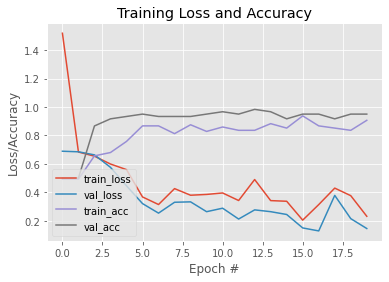

In [9]:
model = Sequential()
model.add(Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=(224,224,3)))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1,activation='sigmoid'))

model.compile(loss=keras.losses.binary_crossentropy,optimizer='adam',metrics=['accuracy'])

model.summary()

train_datagen=image.ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    
)

test_datagen=image.ImageDataGenerator(
    rescale=1./255,
)

train_generator=train_datagen.flow_from_directory(
    'CovidDataset/Train',
    target_size=(224,224),
    batch_size=32,
    class_mode='binary'
    
)
print(train_generator.class_indices)

validation_generator=test_datagen.flow_from_directory(
    'CovidDataset/Val',
    target_size=(224,224),
    batch_size=32,
    class_mode='binary'
    
)
print(validation_generator.class_indices)

hist=model.fit(
    train_generator,
    steps_per_epoch=4,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=2
)

h = hist.history
h.keys()
print("[INFO] saving covid detector model...")
model.save("covid_detector.model", save_format="h5")

# plot the training loss and accuracy
N = 20
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), h["loss"], label="train_loss")
plt.plot(np.arange(0, N), h["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), h["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), h["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

acc = model.evaluate_generator(generator= train_generator)[1] 

print(f"The accuracy of your model is = {acc*100} %")

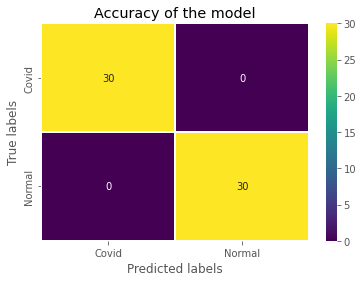

In [12]:
y_actual=[]
y_test=[]

for i in os.listdir('CovidDataset/Val/Normal'):
    img=image.load_img('CovidDataset/Val/Normal/'+i,target_size=(224,224))
    img=image.img_to_array(img)
    img=np.expand_dims(img,axis=0)
    p = (model.predict(img) > 0).astype("int32")
    y_test.append(p[0,0])
    y_actual.append(1)
    
    
for i in os.listdir('CovidDataset/Val/Covid'):
    img=image.load_img('CovidDataset/Val/Covid/'+i,target_size=(224,224))
    img=image.img_to_array(img)
    img=np.expand_dims(img,axis=0)
    p = (model.predict(img) < 0).astype("int32")
    y_test.append(p[0,0])
    y_actual.append(0)
    
y_actual=np.array(y_actual)
y_test=np.array(y_test)

cm=confusion_matrix(y_actual,y_test)

ax= plt.subplot()
sns.heatmap(cm,linewidths=2,cmap='viridis',annot=True,fmt='g',ax=ax)

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Accuracy of the model')
ax.xaxis.set_ticklabels(['Covid', 'Normal']); ax.yaxis.set_ticklabels(['Covid', 'Normal']);
plt.savefig("confusion matrix.png") 

Name: Taki
ID:  482
Age: 21
X-ray report: Dataset/normal/IM-0147-0001.jpeg


The given X-Ray image is of type = Normal

The chances of image being Normal is : 91.90794229507446 percent


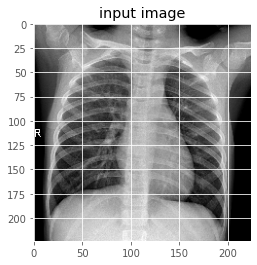

In [10]:
from keras.preprocessing import image
import matplotlib.pyplot as plt
from fpdf import FPDF
from PIL import Image
from datetime import datetime
import pyttsx3
import numpy as np
#from tensorflow import keras
from tensorflow.keras.models import load_model

def get_img_array(img_path):
  """
  Input : Takes in image path as input 
  Output : Gives out Pre-Processed image
  """
  path = img_path
  img = image.load_img(path, target_size=(224,224,3))
  img = image.img_to_array(img)/255
  img = np.expand_dims(img , axis= 0 )
  
  return img

converter = pyttsx3.init()
voice_id = "HKEY_LOCAL_MACHINE\SOFTWARE\Microsoft\Speech\Voices\Tokens\TTS_MS_EN-US_ZIRA_11.0"
converter.setProperty('voice', voice_id)  
converter.setProperty('rate', 170)
converter.setProperty('volume', 1)

pdf = FPDF()
pdf.add_page()

pdf.set_font("Helvetica", 'BU',size = 12)
pdf.cell(200, 10, txt = "COVID detection using X-ray report",ln = 1, align = 'C')

Name = input('Name: ')
ID   = input('ID:  ')
Age  = input('Age: ')
path = input('X-ray report: ')  
Time=datetime.date(datetime.now())

pdf.image(path,x=65,y=75,w=90,h=90)

pdf.set_font("Arial",size = 10)
pdf.cell(10, 10, txt = f'Time:  {Time}',ln =2, align = 'L')
pdf.cell(10, 10, txt = f'Patient\'s Name: {Name}',ln =3, align = 'L')
pdf.cell(10, 10, txt = f'Age: {Age}',ln =4, align = 'L')
# you can add any image path Dataset/covid/0a7faa2a.jpg
#path="Dataset/covid/0a7faa2a.jpg"
#predictions: path:- provide any image from google or provide image from all image folder
class_type = {0:'Covid',  1 : 'Normal'}
#model = keras.models.load_model('covid_detector')
myModel= load_model("covid_detector.model")
img = get_img_array(path)
res = class_type[round(myModel.predict(img)[0][0])]
print()
print()
print(f"The given X-Ray image is of type = {res}")
print()
pdf.set_font("Arial", 'BU',size = 12)
pdf.cell(200,10, txt = "Patient's xray report",ln = 6, align = 'C')



pdf.set_font("Arial",size = 12)
pdf.set_text_color(247, 13, 26)
pdf.cell(200, 10, txt = f"Result type: {res}",ln =1, align = 'C')


if res=='Covid':
    print(f"The chances of image being Covid is : {100-myModel.predict(img)[0][0]*100} percent")
    pdf.cell(200, 0, txt = f"Accuracy : {round(100-myModel.predict(img)[0][0]*100,2)}%",ln =2, align = 'C')
    converter.say(f"Hello {Name}, your x-ray report is ready. It shows a high-risk of covid. Please consult to a specialist as soon as posible.Wishing you a speedy recovery. Thank you")
else:
    print(f"The chances of image being Normal is : {myModel.predict(img)[0][0]*100} percent")
    pdf.cell(200, 0, txt = f"Accuracy: {round(myModel.predict(img)[0][0]*100,2)}%",ln =2, align = 'C')
    converter.say(f"Hello {Name}, your x-ray report is ready. It's absolutely fine. Take Care. Thank you")


pdf.output(f"{Name}_{ID}_report.pdf")
converter.runAndWait()
# to display the image  
plt.imshow(img[0], cmap = "gray")
plt.title("input image")
plt.show()
#Dataset/normal/IM-0147-0001.jpeg


           




         
            